In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from pprint import pprint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
import pickle
import os

def read_or_pickle(path, load_default):
    path += '.pickle'
    if os.path.isfile(path):
        pickle.load(open(path, 'rb'))
    else:
        pickle.dump(load_default(), open(path, 'wb'))

def load_doc():
    nlp = spacy.load('en_core_web_sm')
    book = gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(84)).strip()
    return nlp(book)
        
doc = read_or_pickle('doc', load_doc)

In [4]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input, previous_hidden):
        output, hidden = self.gru(input, previous_hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.rand(1, 1, self.hidden_size, device=device)

In [5]:
def input_tensor(chars, vocab):
    tensor = torch.zeros(len(chars) + 1, 1, len(vocab) + 1, device=device)
    tensor[0][0][len(vocab)] = 1 # START TOKEN
    for i in range(len(chars)):
         tensor[i + 1][0][vocab.index(chars[i])] = 1
    return tensor

def target_tensor(chars, vocab):
    indexes = [vocab.index(char) for char in chars]
    indexes.append(len(vocab)) # END TOKEN
    tensor = torch.tensor(indexes, device=device)
    tensor.unsqueeze_(-1)
    return tensor

In [6]:
def train(input, target, net, criterion, optimizer):
    hidden = net.init_hidden()
    net.zero_grad()
    loss = 0
    output, hidden = net(input, hidden)
    for pred, target in zip(output, target):
        loss += criterion(pred, target)
        
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
def run_train(vocab, inputs, net, criterion, optimizer, plot_every=100):
    losses = []
    loss = 0
    
    for i, input in tqdm(list(enumerate(inputs))):
        loss += train(input_tensor(input, vocab), target_tensor(input, vocab), net, criterion, optimizer)

        if DEBUG: return

        if i % plot_every == 0:
            if LIVE_PLOT:
                 liveloss.update({'loss': loss / plot_every})
                 liveloss.draw()
                
            losses.append(loss / plot_every)
            loss = 0
        

    plt.figure()
    plt.plot(losses)
    
    return losses[-1]
    

In [11]:
vocab = list(set(book))
sents = list(doc.sents)[10:]
sents = filter(lambda sent: len(sent.text.split(' ')) > 4, sents)
sents = map(lambda sent: list(filter(lambda char: char != '\n', sent.text)), sents)
sents = list(sents)

200.4225609588623

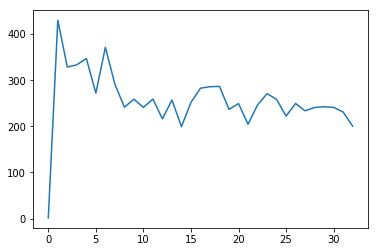

In [12]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()
net = Net(len(vocab) + 1, 100, len(vocab) + 1).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)


run_train(vocab, sents, net, criterion, optimizer)

In [10]:
def sample(vocab, net, max_length=100, beam_number=20):
    with torch.no_grad(): 
        output_sents = []
        beams = [(net.init_hidden(), [''])]
        
        for i in range(max_length):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                tensor = input_tensor(result[-1], vocab)
                output, hidden = net(tensor, hidden)
                
                output_pairs += map(lambda pair: (pair[0], pair[1].item(), beami), enumerate(output[0][0]))
                new_hidden.append(hidden)
            
            output_pairs.sort(key=lambda pair: pair[1], reverse=True)
            
            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                result = list(beams[beami][1])
                
                if outi == len(vocab): # END TOKEN
                    output_sents.append(result)
                else:
                    char = vocab[outi]
                    result.append(char)
                    
                    if i == max_length - 1:
                        output_sents.append(result)
                    else:
                        new_beams.append((new_hidden[beami].clone(), result))
            beams = new_beams
            
        return list(map(''.join, output_sents))
    
result = sample(vocab, net)
print('\n\n'.join(result))

  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e 

i                                                                                                   

a                                                                                                   

l  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

n  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

m  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

h  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

r  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

w  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e

In [16]:
torch.nn.Embedding(10, 100)(torch.zeros(10, dtype=torch.long))

tensor([[ 3.6958e-02, -1.6482e-01, -8.4014e-01, -7.2838e-04, -6.2498e-01,
         -1.6834e+00,  9.8651e-01, -1.7589e-01, -6.8214e-01,  2.2659e+00,
         -7.4646e-01, -1.2143e+00,  8.8906e-01, -4.7853e-01,  9.8526e-01,
          2.6585e-02, -5.2577e-02,  1.0479e-02, -5.8581e-01, -9.5373e-01,
         -1.3177e+00,  8.8428e-02, -8.4953e-01, -1.9724e-01,  7.0988e-02,
          4.2841e-01,  3.5595e-01, -4.0673e-01, -2.7394e-01,  8.3432e-01,
         -1.4549e+00,  5.0061e-01,  4.6554e-01, -1.5001e+00, -4.3242e-01,
          6.2482e-04,  1.0656e+00, -8.6865e-01, -3.5522e-01, -1.5366e+00,
          1.6495e-01,  1.3454e-01, -5.7203e-01,  1.2386e+00, -2.0703e-01,
          1.5366e-01,  8.3636e-03, -1.3244e+00,  9.2644e-01,  9.0379e-01,
         -2.1731e+00, -1.0917e+00,  8.2132e-01,  1.4096e-01,  8.8727e-01,
         -1.9193e-01, -1.1936e+00, -2.1138e-02,  7.7005e-01, -6.8694e-01,
         -4.5946e-01,  1.8884e+00,  1.3504e+00,  9.9454e-01,  2.7288e-01,
          5.0644e-01,  2.4798e-02,  3.